In [1]:
# Load the libraries
import pandas as pd
import numpy  as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import warnings
import platform
import sys
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter("ignore")

# Making the plots standard 
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 5]

In [2]:
#import the training data and test data pickles 
train_df = pd.read_pickle("train_df.pickle")
test_df  = pd.read_pickle("test_df.pickle")

#get the training std 
trainrtt_mean = train_df['last_rtt'].mean()
trainrtt_std = train_df['last_rtt'].std()

In [3]:
cols_dropped = ['date','last_rtt','normalizzed_rtt','src_names']

X_train = train_df.drop(columns=cols_dropped, axis=1)
y_train = train_df['normalizzed_rtt']

X_test = test_df.drop(columns=cols_dropped, axis=1)
y_test = test_df['normalizzed_rtt'] 

In [4]:
# using a simple linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a linear regression model
model = LinearRegression()

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print evaluation metrics
sample_size = len(y_test)
numerator_rmse = abs(y_pred - y_test)**2 
numerator_std = abs(y_pred - y_test.mean())**2
denominator = sample_size - 1

#loss function for linear regression
rmse_lm = np.sqrt(mean_squared_error(y_test, y_pred))
drmse_lm = rmse_lm * trainrtt_std
print(f'RMSE for Linear Regression: ', rmse_lm, 'denormalised rmse linear regression: ', drmse_lm)

RMSE for Linear Regression:  0.230752419206071 denormalised rmse linear regression:  2.155701019976201


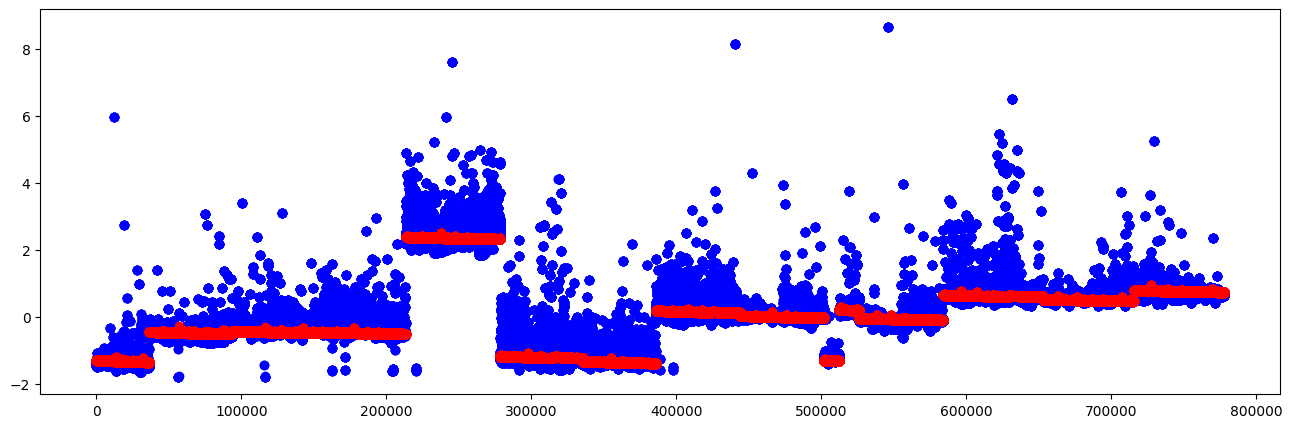

In [5]:
#plot the test rtt values against the number of samples 
# https://stackoverflow.com/questions/65539013/how-to-plot-a-graph-of-actual-vs-predict-values-in
plt.scatter(range(len(y_test)), y_test, color='blue')
plt.scatter(range(len(y_pred)), y_pred, color='red')

In [6]:
#DECISION TREE REGRESSION
# Using a decison tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Create a linear regression model
dt_model = DecisionTreeRegressor(
    criterion='squared_error',  # This is the function used to measure the quality of a split (Mean Squared Error)
    splitter='best',  # Strategy used to split at each node. 'best' finds the best split, 'random' selects random.
    max_depth=None,   # The maximum depth of the tree. None means nodes are expanded until all leaves are pure.
    random_state=42   # Seed used by the random number generator for randomness. Setting this ensures reproducibility.
)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dt_model.predict(X_test)

# Evaluate the model
sample_size = len(y_test)
numerator = abs(y_pred - y_test)**2
denominator = sample_size - 1

#loss function for decision tree
rmse_dt = np.std(y_pred)
drmse_dt = rmse_dt * trainrtt_std
print(f'RMSE for Decision Tree: ', {rmse_dt}, 'denormalised rmse: ', {drmse_dt})


RMSE for Decision Tree:  {0.9999993570775314} denormalised rmse:  {9.342045649811604}


In [7]:
#RANDOM FOREST REGRESSION
# Using a random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree,export_text

# create an instance of the regression tree model and set the hyperparameters 

rand_forest = RandomForestRegressor(
    n_estimators=10 ,  # The number of trees in the forest.
    criterion='squared_error',   # This is the function used to measure the quality of a split (Mean Squared Error)
    max_depth=None,    # The maximum depth of the trees. None means nodes are expanded until all leaves are pure.
    random_state=42,    # Seed used by the random number generator for randomness.
    max_leaf_nodes=None,   # Grow trees with max_leaf_nodes in best-first fashion.
    min_impurity_decrease=0.0,   # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    bootstrap=True,  # Whether bootstrap samples are used when building trees.
    oob_score=False,  # Whether to use out-of-bag samples to estimate the generalization accuracy.
    n_jobs=None,   # The number of jobs to run in parallel for both fitting and predicting.
)

# fit the model to the training data
rand_forest.fit(X_train, y_train)

# make predictions on the testing data
y_pred = rand_forest.predict(X_test)

#loss function for the random forest regressor
sample_size = len(y_test)
numerator = abs(y_pred - y_test)**2
denominator = sample_size - 1

#loss function for random forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
drmse_rf = rmse_rf * trainrtt_std
print(f'RMSE for Random Forest: ', rmse_rf, 'Denormalised rmse rf: ', drmse_rf)

RMSE for Random Forest:  0.0016746151048949692 Denormalised rmse rf:  0.015644340813891065


In [8]:
#XGBOOST REGRESSION
# https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
# https://stackoverflow.com/questions/62176516/how-to-visualize-an-xgboost-tree-from-gridsearchcv-output#62178005

# Using a xgboost regressor
from xgboost import XGBRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
regressor= XGBRegressor()

# exhaustively search for the optimal hyperparameters
param_grid = {"max_depth":    [4, 5, 6],
            "n_estimators": [50, 60, 70],
            "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
grid_search = GridSearchCV(regressor, param_grid).fit(X_train, y_train)

print("The best hyperparameters are ",grid_search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 70}


In [9]:
regressor=XGBRegressor(learning_rate = grid_search.best_params_["learning_rate"],
                        n_estimators  = grid_search.best_params_["n_estimators"],
                        max_depth     = grid_search.best_params_["max_depth"],
                        objective     = 'reg:squarederror')
                        


regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Calculate the mean squared error
sample_size = len(y_test)
numerator = abs(y_pred - y_test)**2
denominator = sample_size - 1
xgb_std = np.std(y_pred)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_drmse = xgb_rmse * trainrtt_std
print(f'RMSE for XGBoost: ', xgb_rmse, 'Denormalised RMSE: ', xgb_drmse)

RMSE for XGBoost:  0.43620729917411827 Denormalised RMSE:  4.075071121620425


In [10]:
#KNN REGRESSION
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Create an instance of the KNN regressor
knn = KNeighborsRegressor(n_neighbors=5,weights='distance')

# Fit the model on the training data
knn.fit(X_train, y_train)

# Make a prediction on the testing data
y_pred = knn.predict(X_test)

# Evaluate the model using mean squared error
sample_size = len(y_test)
numerator = abs(y_pred - y_test)**2
denominator = sample_size - 1
knn_std = np.std(y_pred)

knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
knn_drmse = knn_rmse * trainrtt_std
print(f'RMSE for KNN: ', knn_rmse, 'Denormalised RMSE: ', knn_drmse)

RMSE for KNN:  0.0007570663466836802 Denormalised RMSE:  0.007072552917758219
